# 0. Imports

In [31]:
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scipy
!pip install python-dotenv
!pip install scikit-learn
!pip install fancyimpute

In [32]:
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 1000)

from sklearn.covariance import EllipticEnvelope

import matplotlib.pyplot as plt

from scipy import stats

from dotenv import load_dotenv
load_dotenv()
import os

# 1. Coletar dados

Fizemos o scrap do site olx, setado para categoria de imoveis em recife, primeiros o extract_single_link.py para pegar os links dos sites, criamos e juntamos um json com esses links e depois fomos em cada um desses link usando scraping.py e criamos um csv com todos os dados colotados.

| Campop               | Descrição                                      |
|----------------------|--------------------------------------------------|
| find_anuncio         | o titulo do anuncio                              |
| find_condominio      | o preço do condominio                            |
| find_descri          | a descrição feita do imovel                      |
| find_endereco        | Endereço = bairro, Cidade, estado, cep           |
| find_iptu            | IPTU                                             |
| find_loc             | geralmente a rua                                 |
| find_m_quadrado      | Tamanho do imóvel em metros quadrados            |
| find_price           | Preço do imóvel                                  |
| find_vendedor        | Informações sobre o vendedor                     |
| is_academia          | Indica se há academia/centro de fitness          |
| is_apartamento       | Indica se é um apartamento                       |
| is_ar_condicionado   | Indica se tem ar condicionado                     |
| is_churrasqueira     | Indica se há churrasqueira                       |
| is_elevador          | Indica se há elevador                            |
| is_mobiliado         | Indica se o imóvel está mobiliado                |
| is_piscina           | Indica se há piscina                             |
| is_portaria          | Indica se há portaria/serviço de portaria        |
| is_profissional      | Indica se o vendedor é um profissional           |
| is_salao_festa       | Indica se há salão de festas/área de eventos     |
| is_varanda           | Indica se há varanda                             |
| n_banheiros          | Número de banheiros                              |
| n_fotos              | Número de fotos no anúncio                       |
| n_garagens           | Número de vagas/garagens                         |
| n_quartos            | Número de quartos                                |

In [33]:
path_raw = os.getenv('PATH_RAW')
df_raw = pd.read_csv('scraped_data.csv', sep=',')
# df_raw = pd.read_csv(path_raw, sep=',' nrows=10000)

In [34]:
df_raw.head(3)

,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos
0,Apartamento para venda com 105 metros quadrado...,R$ 1.100 / mês,Código do anúncio: C6BAD9\n\nO apartamento est...,"Aflitos, Recife, PE, 52050340",R$ 180,Rua da Angustura,105m²,380000,Antônio Luciano Santana da Silva,False,True,False,False,False,False,False,False,True,False,False,3,20,0,3
1,Apartamento para venda possui 51 metros quadra...,R$ 0 / mês,Código do anúncio: S623-1\n\nO apartamento no ...,"Boa Viagem, Recife, PE, 51021130",R$ 0,Rua Coronel Anízio Rodrigues Coelho,51m²,525000,Dream Residence Imóveis Recife,False,True,False,False,False,False,True,False,True,True,False,2,15,1,3
2,Apartamento para venda possui 124 metros quadr...,R$ 822 / mês,Código do anúncio: V2009TS-2225\n\nApartamento...,"Boa Viagem, Recife, PE, 51130000",R$ 291,Avenida Boa Viagem - de 6200/6201 ao fim,124m²,620000,Roberta Gadelha Batista,False,True,False,False,False,False,False,False,True,False,False,2,14,1,3


# 2. Realizar pré-processamento dos dados

In [35]:
df_raw.shape

(75922, 24)

In [36]:
df_0 = df_raw.copy()

Vamos tirar a descrição e anuncio, pois está fora do escopo do projeto fazer analise com esse tipo de texto

In [37]:
df_0 = df_0.drop(columns=['find_anuncio','find_descri']) 

Vamos separar o bairro e o cep

In [38]:
df_0[['Bairro','CEP']] = df_0['find_endereco'].str.split(', ', expand=True)[[0,3]]


vamos remover as duplicadas e a coluna de endereço

In [39]:
df_0 = df_0.drop(columns=['find_endereco'])
df_0 = df_0.drop_duplicates()

In [40]:
df_0.shape

(68034, 23)

## 2.0 Tratamento de dados

### 2.0.1 Algumas classes são muito uteis como valor numerico, mas não podem ser totalmente convertidas. exemplo: o numero de quartos tem o campo '5 ou mais' vamos fazer o drop desses valores

In [41]:
df_0 = df_0[df_0['n_quartos'] != '5 ou mais'] # por recomendação do professor
df_0 = df_0[df_0['n_banheiros'] != '5 ou mais']
df_0 = df_0[df_0['n_garagens'] != '5 ou mais']

# df_0 = df_0[df_0['find_price'] > 10000] # vamos tirar aguns precos muito absurdos # outliers

In [42]:
df_0.shape

(63209, 23)

## 2.1 definição de tipos e criação de novas colunas derivadas

In [43]:
df_0.dtypes

find_condominio       object
find_iptu             object
find_loc              object
find_m_quadrado       object
find_price             int64
find_vendedor         object
is_academia             bool
is_apertamento          bool
is_ar_condicionado      bool
is_churrasqueira        bool
is_elevador             bool
is_mobiliado            bool
is_piscina              bool
is_portaria             bool
is_profissional         bool
is_salao_festa          bool
is_varanda              bool
n_banheiros           object
n_fotos                int64
n_garagens            object
n_quartos             object
Bairro                object
CEP                   object
dtype: object

In [44]:
# deixando como num a coluna find_condominio
df_0['find_condominio'] = df_0['find_condominio'].astype('str').str.replace('R$', '').str.replace(' / mês', '').str.replace('.', '')

# deixando como num a coluna find_iptu
df_0['find_iptu'] = df_0['find_iptu'].astype('str').str.replace('R$ ', '').str.replace('.', '')

# deixando como num a coluna find_m_quadrado
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('str').str.replace('m²', '').str.replace('.', '')

# cast direto colunas(floats devido a conseguir dar cast em NaN)
df_0['find_condominio'] = df_0['find_condominio'].astype('float')
df_0['Bairro'] = df_0['Bairro'].astype('category')
df_0['CEP'] = df_0['CEP'].astype('category')
df_0['find_iptu'] = df_0['find_iptu'].astype('float')
df_0['find_loc'] = df_0['find_loc'].astype('category')
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('float')
df_0['find_price'] = df_0['find_price'].astype('float')
df_0['find_vendedor'] = df_0['find_vendedor'].astype('category')
df_0['is_academia'] = df_0['is_academia'].astype('category')
df_0['is_apertamento'] = df_0['is_apertamento'].astype('category')
df_0['is_ar_condicionado'] = df_0['is_ar_condicionado'].astype('category')
df_0['is_churrasqueira'] = df_0['is_churrasqueira'].astype('category')
df_0['is_elevador'] = df_0['is_elevador'].astype('category')
df_0['is_mobiliado'] = df_0['is_mobiliado'].astype('category')
df_0['is_piscina'] = df_0['is_piscina'].astype('category')
df_0['is_portaria'] = df_0['is_portaria'].astype('category')
df_0['is_profissional'] = df_0['is_profissional'].astype('category')
df_0['is_salao_festa'] = df_0['is_salao_festa'].astype('category')
df_0['is_varanda'] = df_0['is_varanda'].astype('category')
df_0['n_banheiros'] = df_0['n_banheiros'].astype('float')
df_0['n_fotos'] = df_0['n_fotos'].astype('float')
df_0['n_garagens'] = df_0['n_garagens'].astype('float')
df_0['n_quartos'] = df_0['n_quartos'].astype('float')


In [45]:
df_0.dtypes

find_condominio        float64
find_iptu              float64
find_loc              category
find_m_quadrado        float64
find_price             float64
find_vendedor         category
is_academia           category
is_apertamento        category
is_ar_condicionado    category
is_churrasqueira      category
is_elevador           category
is_mobiliado          category
is_piscina            category
is_portaria           category
is_profissional       category
is_salao_festa        category
is_varanda            category
n_banheiros            float64
n_fotos                float64
n_garagens             float64
n_quartos              float64
Bairro                category
CEP                   category
dtype: object

In [46]:
df_0[df_0.select_dtypes(['category']).columns] = df_0.select_dtypes(['category']).apply(lambda x: x.cat.codes)

In [47]:
df_0.dtypes

find_condominio       float64
find_iptu             float64
find_loc                int16
find_m_quadrado       float64
find_price            float64
find_vendedor           int16
is_academia              int8
is_apertamento           int8
is_ar_condicionado       int8
is_churrasqueira         int8
is_elevador              int8
is_mobiliado             int8
is_piscina               int8
is_portaria              int8
is_profissional          int8
is_salao_festa           int8
is_varanda               int8
n_banheiros           float64
n_fotos               float64
n_garagens            float64
n_quartos             float64
Bairro                   int8
CEP                     int16
dtype: object

antes de tratar os dados ausentes vamos retirar anuncios que não fazem sentido 

In [48]:
df_0 = df_0[df_0['find_m_quadrado']!=0]

## 2.2 Tratamento de dados ausentes
  - vamos fazer a imputação das únicas 3 colunas que apresentam preenchimento vazio
    - find_m_quadrado
    - n_banheiros
    - n_garagens

In [49]:
df_0.isna().sum()

find_condominio          0
find_iptu                0
find_loc                 0
find_m_quadrado        496
find_price               0
find_vendedor            0
is_academia              0
is_apertamento           0
is_ar_condicionado       0
is_churrasqueira         0
is_elevador              0
is_mobiliado             0
is_piscina               0
is_portaria              0
is_profissional          0
is_salao_festa           0
is_varanda               0
n_banheiros            114
n_fotos                  0
n_garagens            1682
n_quartos                0
Bairro                   0
CEP                      0
dtype: int64

### 2.2.1 Removendo colunas pelo knnimputer

In [50]:
from fancyimpute import KNN

df_0_knn = KNN(k=2).fit_transform(df_0)

Imputing row 1/63177 with 0 missing, elapsed time: 605.252
Imputing row 101/63177 with 0 missing, elapsed time: 605.340
Imputing row 201/63177 with 0 missing, elapsed time: 605.355
Imputing row 301/63177 with 0 missing, elapsed time: 605.358
Imputing row 401/63177 with 0 missing, elapsed time: 605.367
Imputing row 501/63177 with 0 missing, elapsed time: 605.372
Imputing row 601/63177 with 0 missing, elapsed time: 605.375
Imputing row 701/63177 with 0 missing, elapsed time: 605.384
Imputing row 801/63177 with 0 missing, elapsed time: 605.386
Imputing row 901/63177 with 0 missing, elapsed time: 605.399
Imputing row 1001/63177 with 0 missing, elapsed time: 605.406
Imputing row 1101/63177 with 0 missing, elapsed time: 605.415
Imputing row 1201/63177 with 0 missing, elapsed time: 605.429
Imputing row 1301/63177 with 0 missing, elapsed time: 605.438
Imputing row 1401/63177 with 0 missing, elapsed time: 605.451
Imputing row 1501/63177 with 0 missing, elapsed time: 605.458
Imputing row 1601/63

In [51]:
df_0 = pd.DataFrame(data=df_0_knn[0:,0:],columns=df_0.columns)

In [52]:
df_0.isna().sum()

find_condominio       0
find_iptu             0
find_loc              0
find_m_quadrado       0
find_price            0
find_vendedor         0
is_academia           0
is_apertamento        0
is_ar_condicionado    0
is_churrasqueira      0
is_elevador           0
is_mobiliado          0
is_piscina            0
is_portaria           0
is_profissional       0
is_salao_festa        0
is_varanda            0
n_banheiros           0
n_fotos               0
n_garagens            0
n_quartos             0
Bairro                0
CEP                   0
dtype: int64

## 2.3 Normalização e discretização dos dados

<Axes: xlabel='dist_find_m_quadrado'>

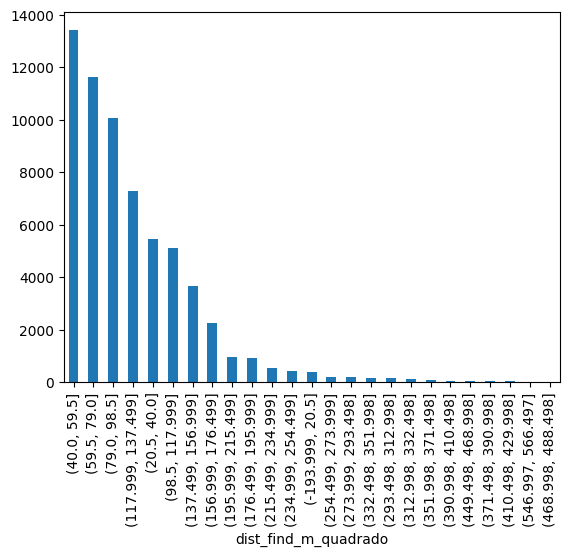

In [53]:
# fazendo a discretização do find_m_quadrado para entender melhor distribuição pelos segmentos
df_disc = df_0.copy()
df_disc['dist_find_m_quadrado'] = pd.cut(df_disc['find_m_quadrado'], bins=10000)

df_disc['dist_find_m_quadrado'].value_counts()[:25].plot(kind='bar')

C:\Users\USER\AppData\Local\Temp\ipykernel_22272\4106164377.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_disc['find_m_quadrado'])


118.55968402266083
80.0


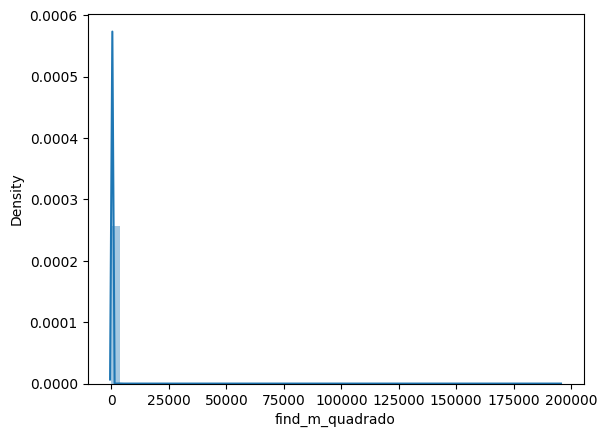

In [54]:
sns.distplot(df_disc['find_m_quadrado'])
print(df_disc['find_m_quadrado'].mean())
print(df_disc['find_m_quadrado'].median())

perceba que a intuição natural de que na a dsitribuição dos possíveis m2 na olx uma assimetria positiva se faz verdade 

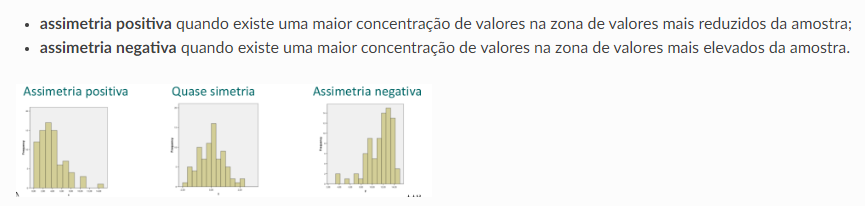

In [55]:
cat_cols = ['find_loc', 'find_vendedor', 'Bairro', 'CEP']

df_0.columns.difference(cat_cols)

Index(['find_condominio', 'find_iptu', 'find_m_quadrado', 'find_price',
       'is_academia', 'is_apertamento', 'is_ar_condicionado',
       'is_churrasqueira', 'is_elevador', 'is_mobiliado', 'is_piscina',
       'is_portaria', 'is_profissional', 'is_salao_festa', 'is_varanda',
       'n_banheiros', 'n_fotos', 'n_garagens', 'n_quartos'],
      dtype='object')

In [56]:
# minmax em todo o dataframe, exceto as colunas categóricas que não fazem sentido normalizar
cat_cols = ['find_loc', 'find_vendedor', 'Bairro', 'CEP']
numeric_cols = df_0.columns.difference(cat_cols)

df_0_norm = df_0[numeric_cols].copy()

df_0_norm[numeric_cols] = (df_0_norm[numeric_cols] - df_0_norm[numeric_cols].min()) / (df_0_norm[numeric_cols].max() - df_0_norm[numeric_cols].min()).copy()

In [57]:
df_0_norm.describe()

,find_condominio,find_iptu,find_m_quadrado,find_price,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos
count,6.317700e+04,6.317700e+04,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000,63177.000000
mean,9.859174e-04,3.276884e-04,0.000603,0.258957,0.444861,0.960777,0.223483,0.422416,0.678902,0.072131,0.626779,0.605568,0.974247,0.631037,0.353657,0.462095,0.779194,0.366966,0.672207
std,1.904087e-02,8.843048e-03,0.009039,0.171597,0.496954,0.194127,0.416583,0.493948,0.466902,0.258706,0.483664,0.488732,0.158399,0.482528,0.478108,0.238595,0.252312,0.166708,0.218203
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.876538e-07,3.508771e-07,0.000277,0.142132,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.250000,0.650000,0.250000,0.500000
50%,1.486419e-04,7.017541e-07,0.000405,0.197628,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.500000,0.900000,0.250000,0.750000
75%,4.197529e-04,1.098245e-04,0.000621,0.328063,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.950000,0.500000,0.750000
max,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.4 Limpeza dos dados

In [58]:
df_1 = df_0.copy()
df_1_norm = df_0_norm.copy()

### 2.4.1 univariado

#### 2.4.1.1 find_price

<Axes: >

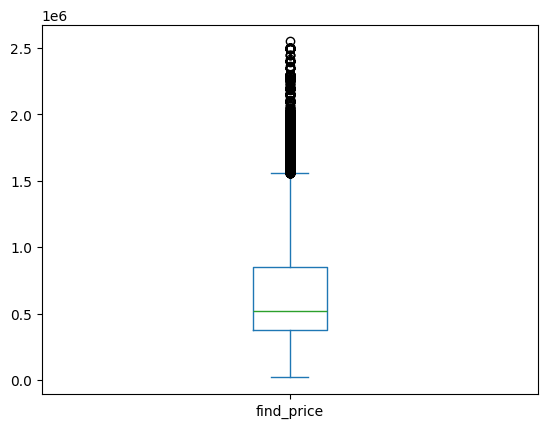

In [59]:
df_1['find_price'].plot.box()

<Axes: >

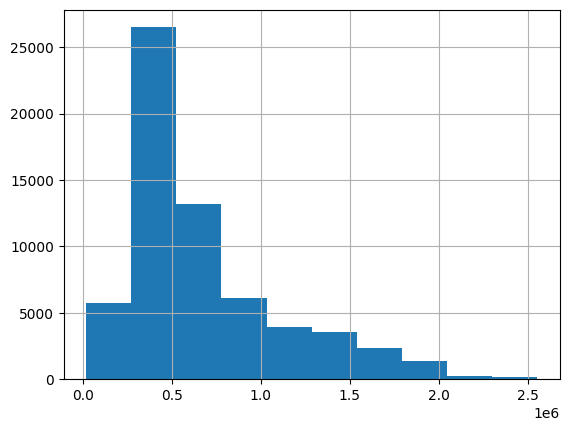

In [60]:
df_1['find_price'].hist()

In [61]:
from numpy import log10

df_1['log_find_price'] = log10(df_1['find_price'])

sem melhoras significativas no shape da distribuição, vamos usar o find_price

<Axes: >

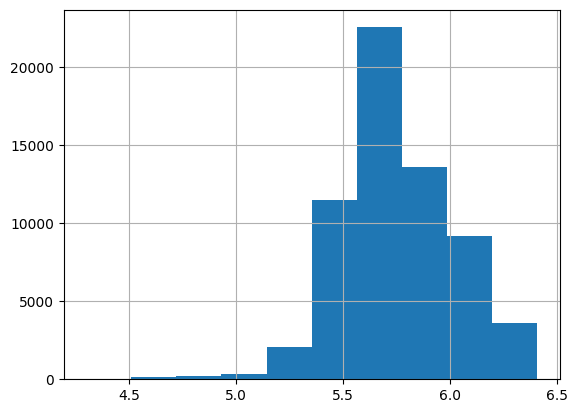

In [62]:
df_1['log_find_price'].hist()

In [63]:
q1 = df_1['find_price'].quantile(q=0.25)
q3 = df_1['find_price'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)


470405.0


In [64]:
# aplicando metodo tukey
print(len(df_1))
df_1 = df_1[(df_1['find_price'] > (q1-1.5*iqr)) & (df_1['find_price'] < (q3+1.5*iqr))]
print(len(df_1))

63177
59514


#### 2.4.1.1 find_m_quadrado

<Axes: >

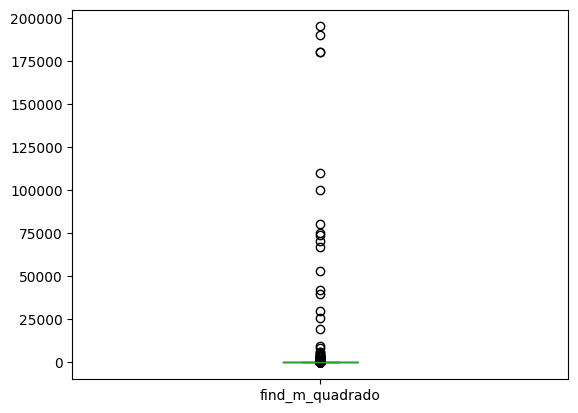

In [65]:
df_1['find_m_quadrado'].plot.box()

<Axes: >

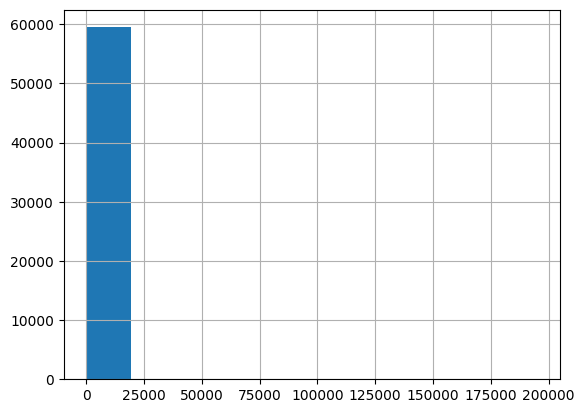

In [66]:
df_1['find_m_quadrado'].hist()

In [67]:
from numpy import log10

df_1['log_find_m_quadrado'] = log10(df_1['find_m_quadrado'])

<Axes: >

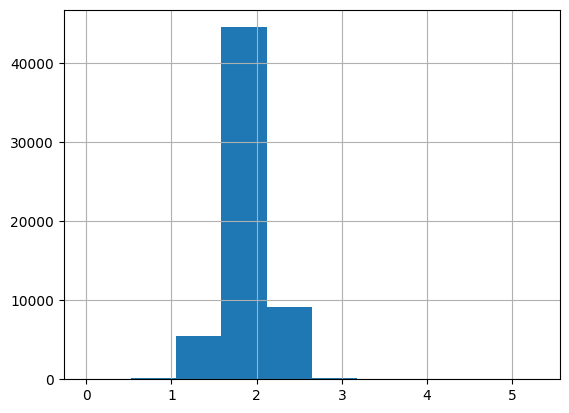

In [68]:
df_1['log_find_m_quadrado'].hist()

Já aqui vemos melhoras significativas no shape da distribuição, se aproximando bem mais de uma distribuição normal, por isso vamos utilizar a coluna log_find_m_quadrado

In [69]:
q1 = df_1['log_find_m_quadrado'].quantile(q=0.25)
q3 = df_1['log_find_m_quadrado'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)


0.32104710918586865


In [70]:
# aplicando metodo tukey
print(len(df_1))
df_1 = df_1[(df_1['log_find_m_quadrado'] > (q1-1.5*iqr)) & (df_1['log_find_m_quadrado'] < (q3+1.5*iqr))]
print(len(df_1))

59514
58953


### 2.4.2 bivariado

<Axes: xlabel='find_price', ylabel='n_banheiros'>

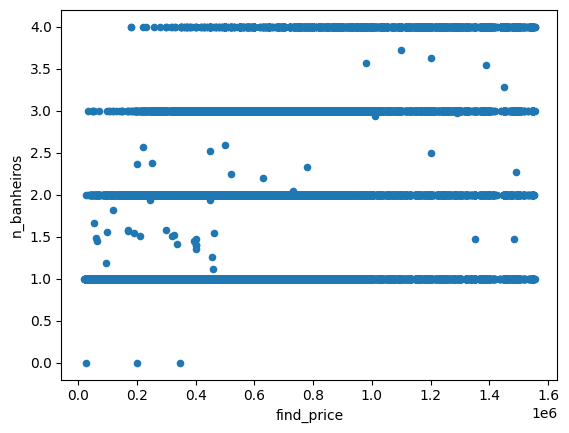

In [71]:
df_1.plot.scatter(x='find_price', y='n_banheiros')

In [72]:
df_1['price_qtdbanheiros'] = df_1['find_price'] / df_1['n_banheiros']

<Axes: >

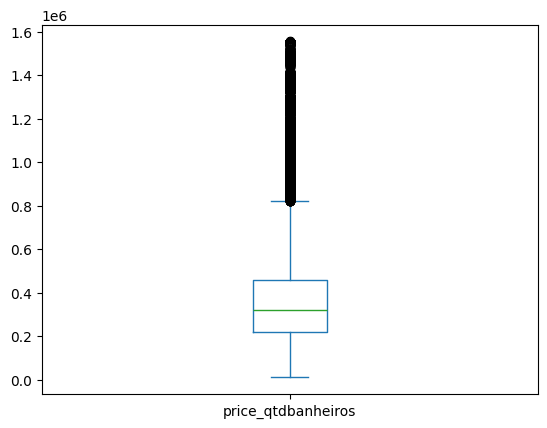

In [73]:
df_1['price_qtdbanheiros'].plot.box()

In [74]:
mad = abs(df_1['price_qtdbanheiros'] - df_1['price_qtdbanheiros'].median()).median()*(1/0.6745)

In [75]:
print(f'volumetria antes: {len(df_1)}')
df_1 = df_1[abs(df_1['price_qtdbanheiros']-df_1['price_qtdbanheiros'].median())/mad < 3.5]
print(f'volumetria depois: {len(df_1)}')

volumetria antes: 58953
volumetria depois: 55776


### 2.4.3 multivariado

In [76]:
detector = EllipticEnvelope(contamination=0.01)
detector.fit(df_1)

EllipticEnvelope(contamination=0.01)

In [77]:
df_1['outlier'] = detector.predict(df_1)
df_1.head(3)

C:\Users\USER\AppData\Local\Temp\ipykernel_22272\1587711812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['outlier'] = detector.predict(df_1)


,find_condominio,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,Bairro,CEP,log_find_price,log_find_m_quadrado,price_qtdbanheiros,outlier
0,1100.0,180.0,2525.0,105.0,380000.0,199.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,20.0,0.0,3.0,0.0,2036.0,5.579784,2.021189,126666.666667,1
1,0.0,0.0,965.0,51.0,525000.0,512.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,15.0,1.0,3.0,11.0,1230.0,5.720159,1.707570,262500.000000,1
2,822.0,291.0,102.0,124.0,620000.0,1747.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,14.0,1.0,3.0,11.0,1391.0,5.792392,2.093422,310000.000000,1


In [78]:
print(f'volumetria antes: {len(df_1)}')
df_1 = df_1[df_1['outlier'] != -1]
print(f'volumetria depois: {len(df_1)}')
df_1 = df_1.drop(columns=['outlier'])

volumetria antes: 55776
volumetria depois: 55218


# 3. Apresentar estatísticas descritivas dos dados com visualizações

In [79]:
df_2 = df_1.copy()
df_2_norm = df_1_norm.copy()

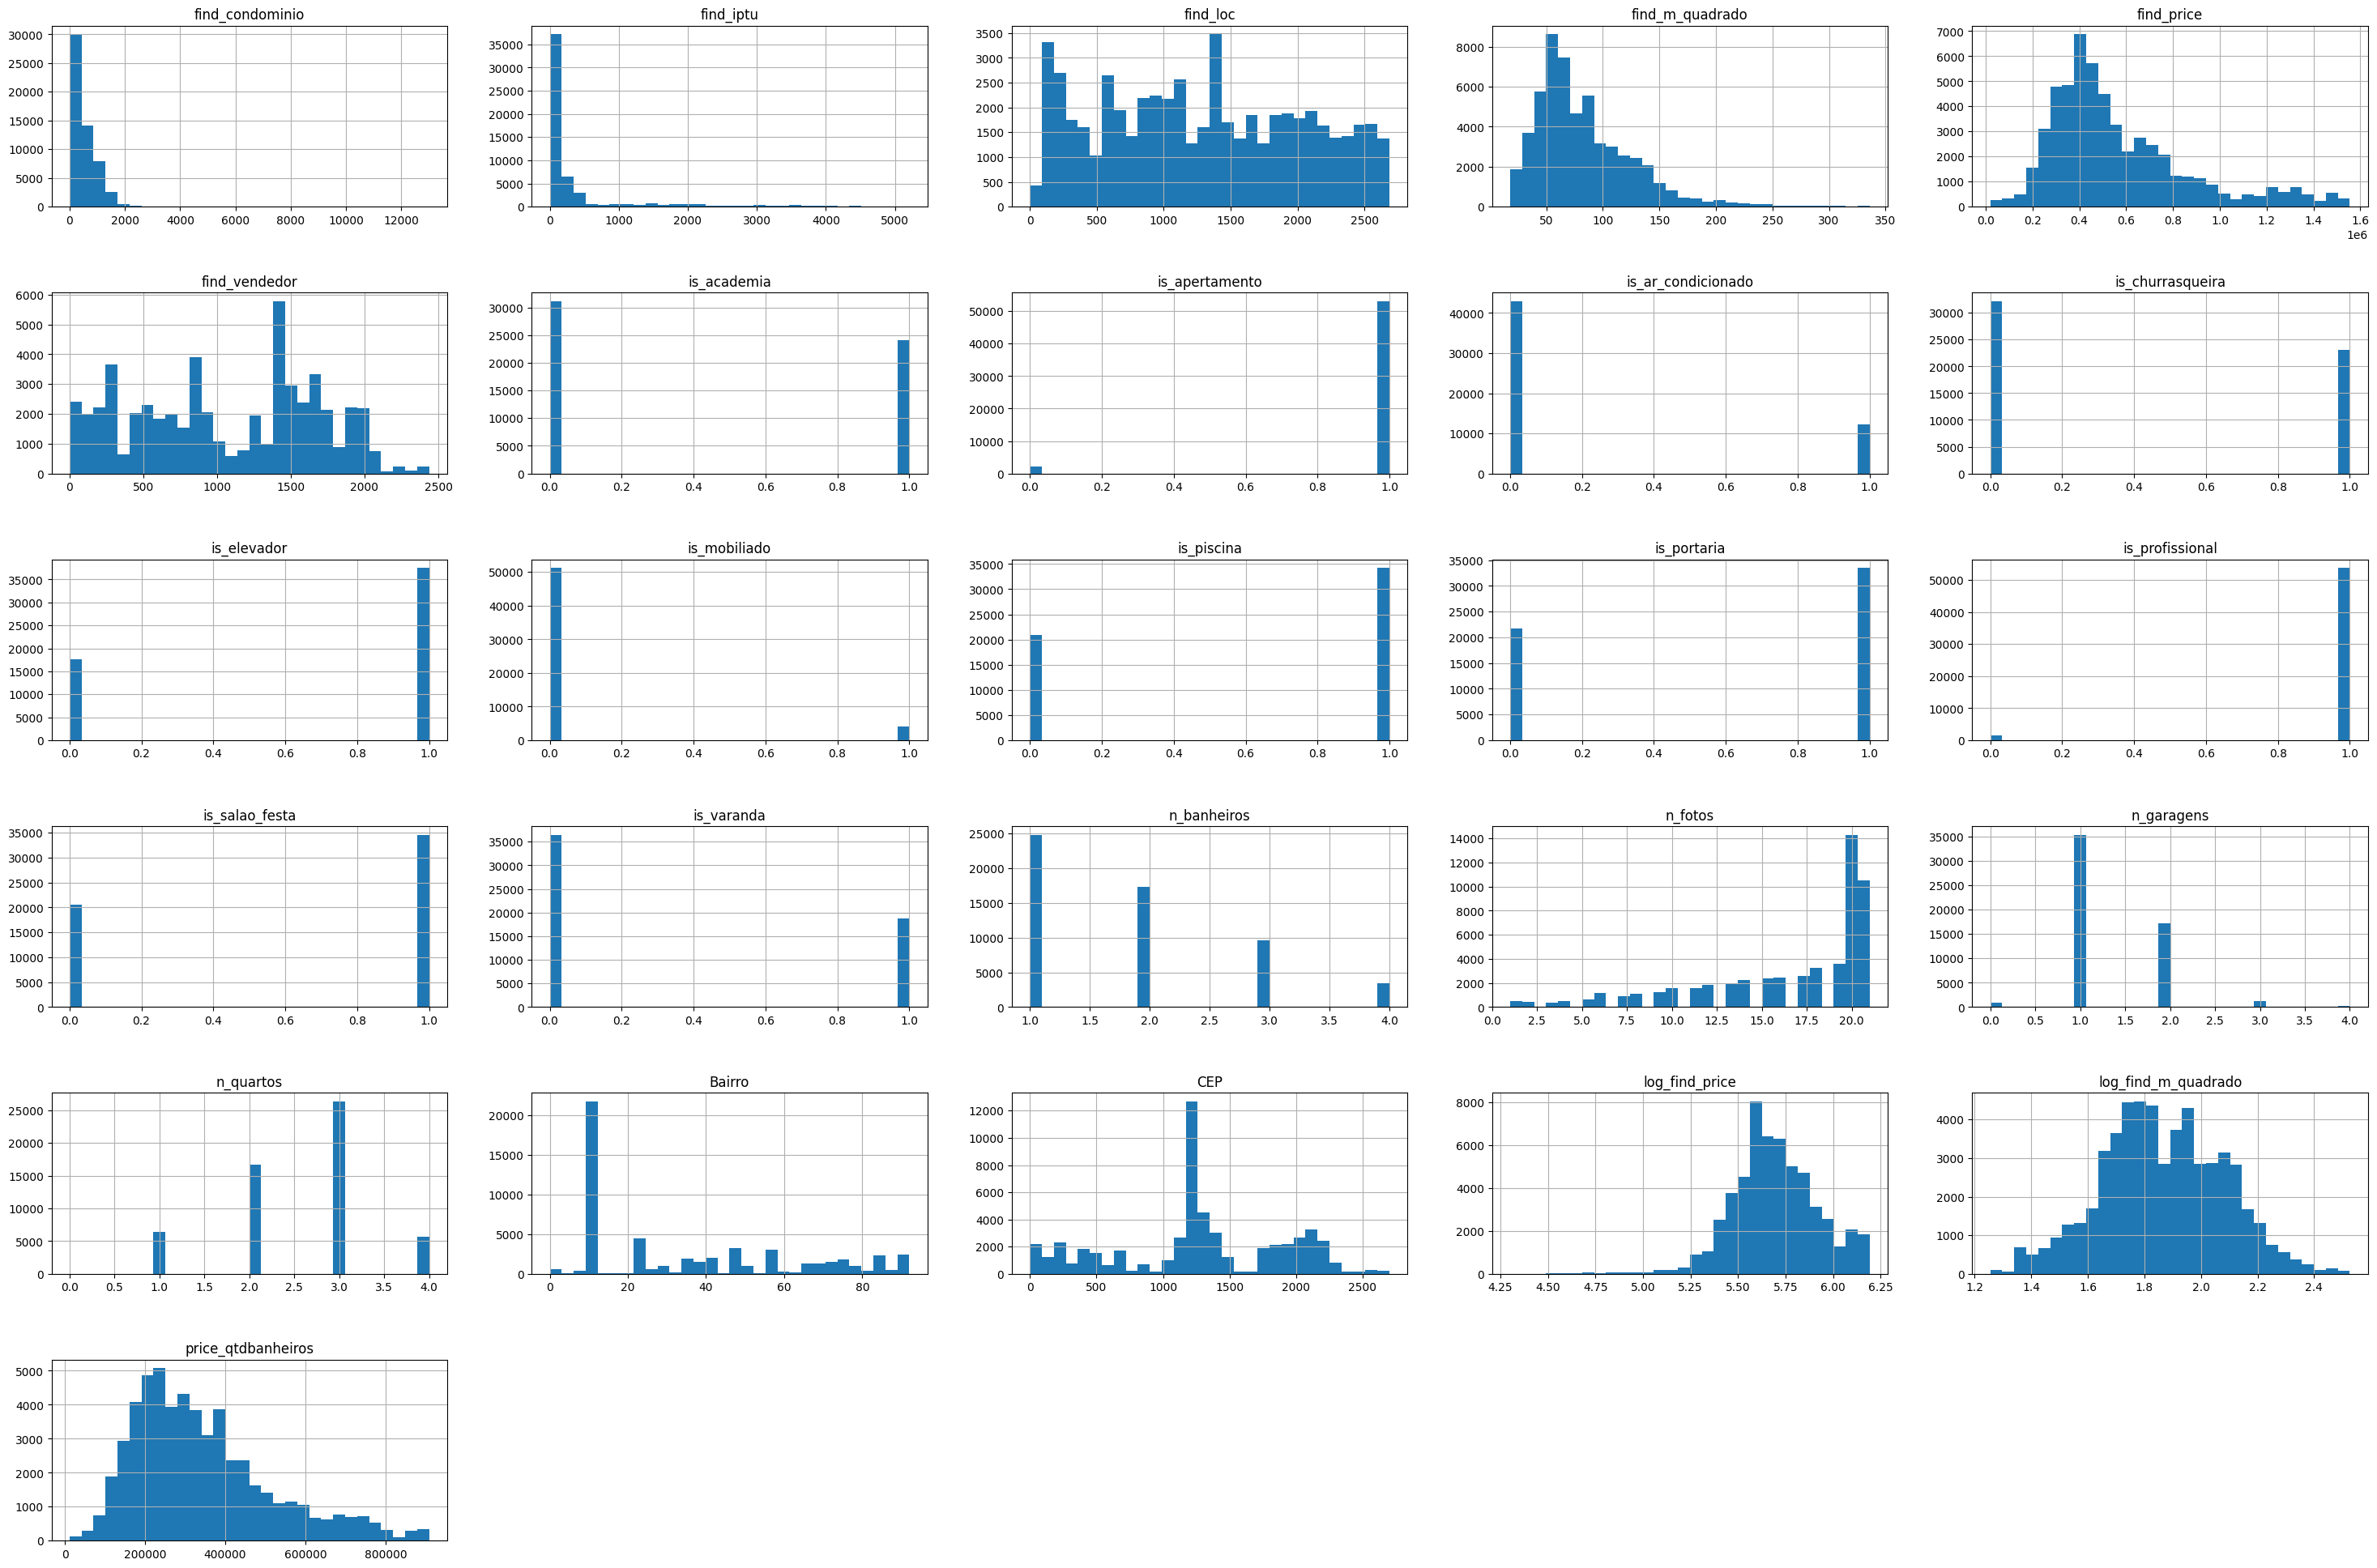

In [80]:
df_2.hist(figsize=(30, 20), bins=30)

plt.tight_layout(pad=3.0)

In [81]:
df_2.describe()

,find_condominio,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,Bairro,CEP,log_find_price,log_find_m_quadrado,price_qtdbanheiros
count,55218.000000,55218.000000,55218.000000,55218.000000,5.521800e+04,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000,55218.000000
mean,429.098971,397.910899,1287.473958,82.748592,5.648032e+05,1058.645931,0.436053,0.962041,0.221812,0.416984,0.679489,0.072150,0.619997,0.606867,0.972871,0.627006,0.339310,1.847398,16.418378,1.352660,2.567623,36.436651,1273.793853,5.694657,1.864066,342560.319326
std,510.111856,878.173680,753.955132,43.363169,3.008149e+05,618.224674,0.495898,0.191098,0.415469,0.493065,0.466677,0.258739,0.485392,0.488450,0.162460,0.483605,0.473479,0.920296,5.067973,0.576412,0.829465,27.356970,636.811026,0.227099,0.216036,171877.075719
min,-1.000000,-1.000000,0.000000,18.000000,2.000000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,4.301030,1.255272,11666.666667
25%,1.000000,0.000000,640.500000,52.000000,3.601930e+05,521.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,13.000000,1.000000,2.000000,11.000000,1034.000000,5.556535,1.716003,215000.000000
50%,275.000000,1.000000,1286.000000,71.000000,4.800000e+05,1046.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,19.000000,1.000000,3.000000,25.000000,1247.000000,5.681241,1.851258,303178.833333
75%,777.000000,270.000000,1912.750000,105.000000,6.999990e+05,1580.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,20.000000,2.000000,3.000000,57.000000,1824.000000,5.845097,2.021189,430000.000000
max,13000.000000,5208.000000,2687.000000,336.000000,1.555094e+06,2437.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,21.000000,4.000000,4.000000,92.000000,2702.000000,6.191757,2.526339,908698.000000


# 4. Realizar teste de hipóteses para comparação de valores de categorias e visualizar diferenças

In [82]:
df_3 = df_2.copy()
df_3_norm = df_2_norm.copy()

## 4.1 Existe diferença significativa no preço médio entre imóveis com piscina e imóveis sem piscina?
  - Mann Whitney u-test
    - Grupos não pariados
    - Teste não paramétrico
  - (H₀): Não há diferença significativa no preço médio entre imóveis com piscina e imóveis sem piscina.

In [83]:
precos_com_piscina = df_3[df_3['is_piscina'] == 1]['find_price']
precos_sem_piscina = df_3[df_3['is_piscina'] == 0]['find_price']

In [84]:
stats.shapiro(precos_com_piscina) # rejeita hip nula -> não apresenta dist normal

c:\Users\USER\delete_this\.conda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 34235.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=0.867268661656984, pvalue=2.0239358980875797e-95)

In [85]:
stats.shapiro(precos_sem_piscina) # rejeita hip nula -> não apresenta dist normal

c:\Users\USER\delete_this\.conda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20983.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=0.9109515237333938, pvalue=2.878660636539087e-75)

<Axes: >

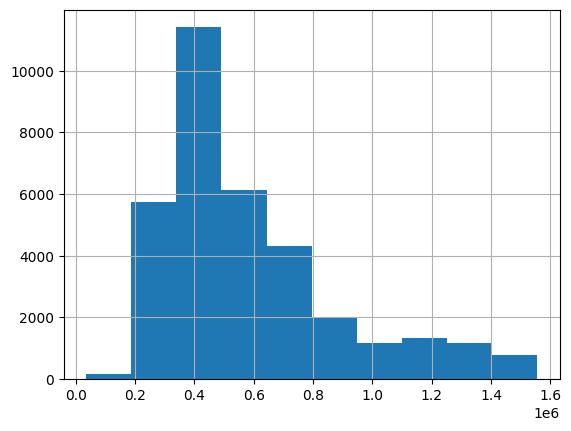

In [86]:
precos_com_piscina.hist()

<Axes: >

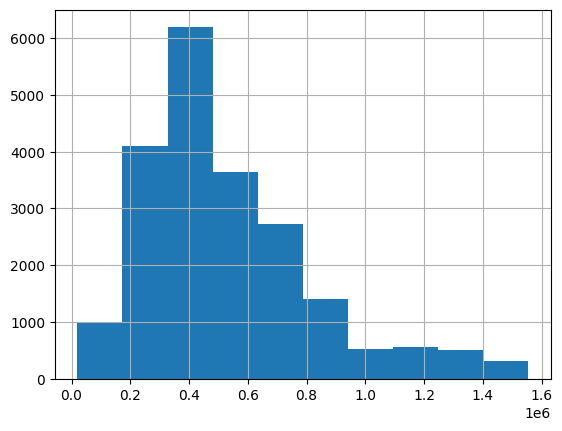

In [87]:
precos_sem_piscina.hist()

In [88]:
stat, p_value = stats.mannwhitneyu(precos_com_piscina, precos_sem_piscina, alternative='two-sided')
print(f"Statistic: {stat}, P-value: {p_value}") # rejeitamos a hipótese nula, ou seja, há uma diferença significativa no preço médio entre imóveis com e sem piscina.

Statistic: 402686743.0, P-value: 1.4168165636028212e-126
